## Modelling heteroscedasticity in Stan: Should I invest in the Stock Market?
* https://www.youtube.com/watch?v=nwuU-KEKXhU&list=PLCrWEzJgSUqwL85xIj1wubGdY15C5Gf7H&index=6
* https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity
* Homogeneity : Subsamples within the dataset have the **same** or similary statistical properties as the full dataset.
* Homoscedasticity : Homegeneity of variance. The variance of the residuals is constant across all levels of the independent variable.
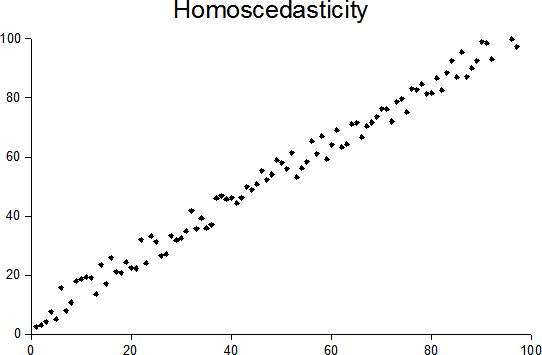

* Heterogeneity : Subsamples within the dataset have **different** statistical properties as the full dataset.
* Heteroscedasticity : The variance of the residuals is not constant across all levels of the independent variable.
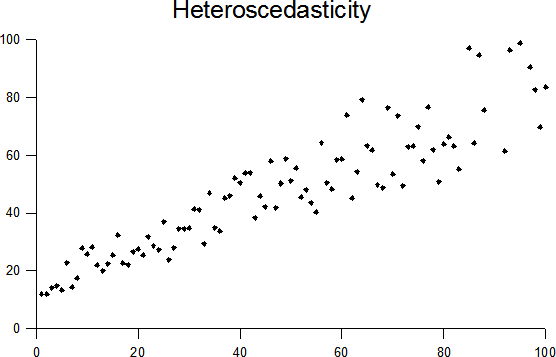

In [32]:
import numpy as np

import stan
import arviz as az
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
nest_asyncio.apply()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
n = 100
a = 0.4
b = 1.3

In [34]:
x = np.linspace(0, 10, n)
y = a + b * x + np.random.normal(0, 0.3, n) * x

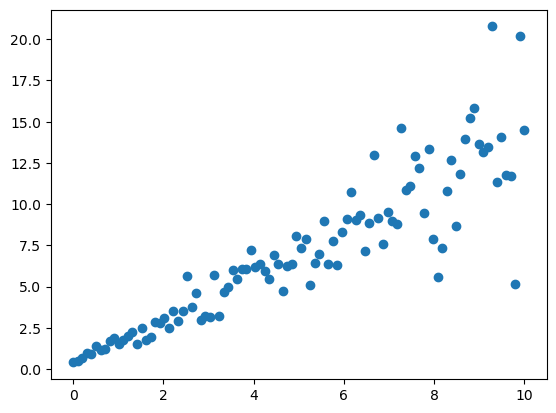

In [35]:
plt.plot(x, y, "o")

In [36]:
stan_code = """
data {
    int<lower=0> N; // number of data points
    vector[N] x; 
    vector[N] y;
    }

parameters {
    real alpha; // intercept
    real beta; // slope
    real<lower=0> sigma; // scatter noise
    }

model {
// prior
alpha ~ normal(0, 10);
beta ~ normal(0, 10);
sigma ~ cauchy(0, 1);

// likelihood
y ~ normal(alpha + beta * x, sigma);
}
"""

In [37]:
data = {"N": n, "x": x, "y": y}

In [38]:
sm = stan.build(stan_code, data=data)

Building...



Building: found in cache, done.

In [39]:
fit = sm.sample(num_chains=4, num_samples=1000)

Sampling:   0%


Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_0g5o_jgi/model_42asriw3.stan', line 21, column 0 to column 36)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expecta

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

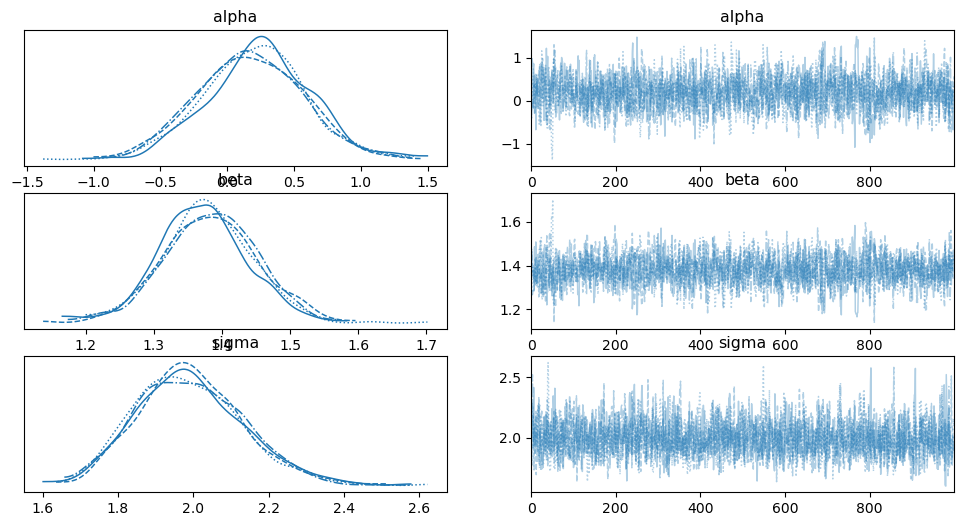

In [40]:
az.plot_trace(fit)

array([[<Axes: ylabel='beta'>, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='sigma'>, <Axes: xlabel='beta'>]],
      dtype=object)

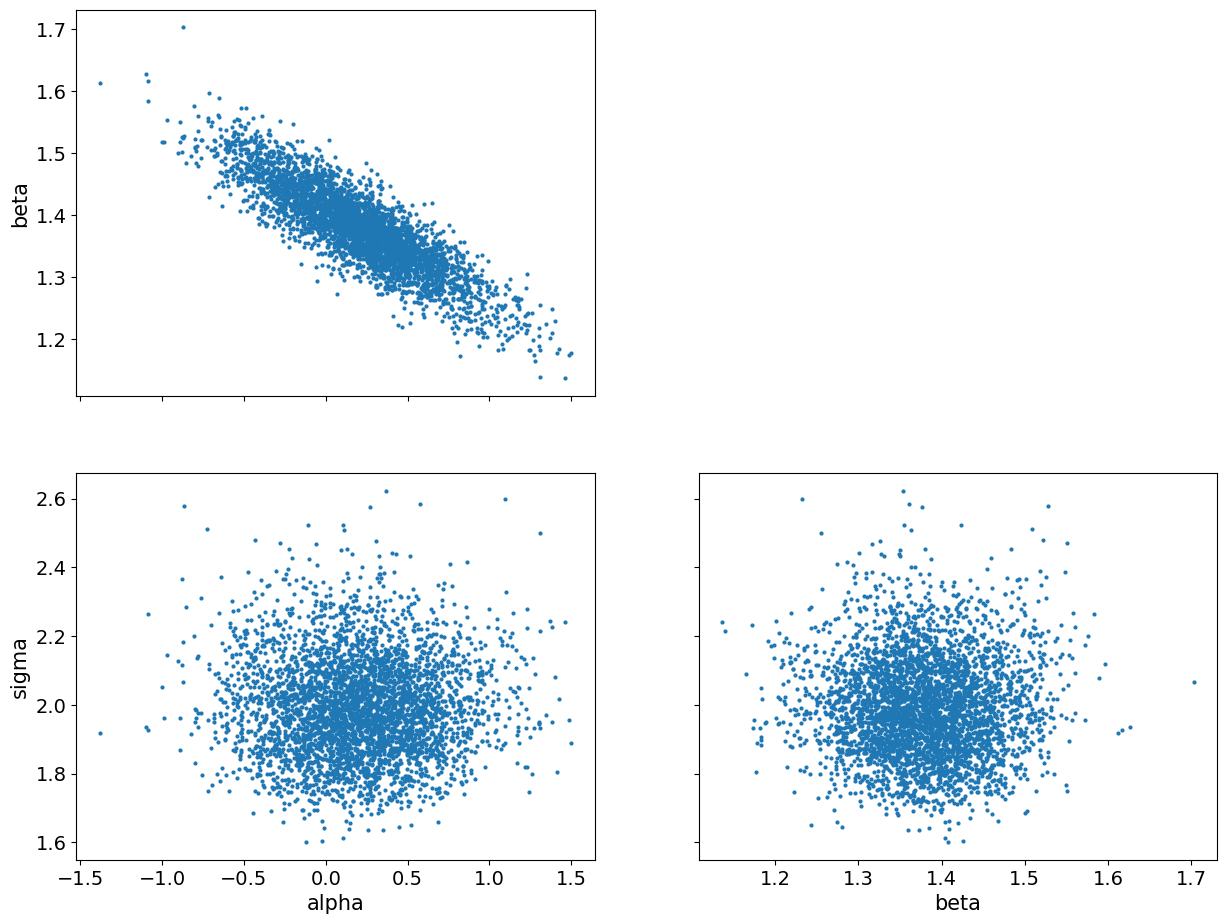

In [41]:
az.plot_pair(fit, var_names=["alpha", "beta", "sigma"])

* reverse relationship between alpha and beta is a problem. 
* The model is not able to capture the heteroscedasticity in the data.


In [54]:
stan_code = """
data {
    int<lower=0> N; // number of data points
    vector[N] x; 
    vector[N] y;
    }

parameters {
    real alpha; // intercept
    real beta; // slope
    real<lower=0> sigma; // scatter noise

    }


model {
    // prior
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);
    sigma ~ cauchy(0, 1);


    // likelihood
    y ~ normal(alpha + beta * x, sigma*x);
}
"""

In [55]:
sm = stan.build(stan_code, data=data)

Building...


Building: 16.7s, done.

In [61]:
# fit = sm.sample(num_chains=4, num_samples=10000, num_warmup=1000)
# this code is note working, because of the error in the model
# `RuntimeError("Initialization between (-2, 2) failed after 100 attempts. Try specifying initial value

#### Volaity in the Stock Market
* Volatility is a measure of the dispersion of returns for a given security or market index.

In [62]:
!pip install yfinance

  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.2/315.2 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.5-py3-none-any.whl.metadata (4.7 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 9.1 MB/s eta 0:00:00
Using cached beauti

In [63]:
import yfinance as yf

# Define the ticker symbol for FTSE
tickerSymbol = "^FTSE"

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period="1d", start="2010-1-1", end="2020-12-31")

# See your data
print(tickerDf)

                                  Open         High          Low        Close  \
Date                                                                            
2010-01-04 00:00:00+00:00  5412.899902  5500.299805  5410.799805  5500.299805   
2010-01-05 00:00:00+00:00  5500.299805  5536.399902  5480.700195  5522.500000   
2010-01-06 00:00:00+00:00  5522.500000  5536.500000  5497.700195  5530.000000   
2010-01-07 00:00:00+00:00  5530.000000  5551.700195  5499.799805  5526.700195   
2010-01-08 00:00:00+00:00  5526.700195  5549.299805  5494.799805  5534.200195   
...                                ...          ...          ...          ...   
2020-12-21 00:00:00+00:00  6529.200195  6529.200195  6315.299805  6416.299805   
2020-12-23 00:00:00+00:00  6453.200195  6497.299805  6431.200195  6495.799805   
2020-12-24 00:00:00+00:00  6495.799805  6530.299805  6479.600098  6502.100098   
2020-12-29 00:00:00+00:00  6502.100098  6676.600098  6502.100098  6602.700195   
2020-12-30 00:00:00+00:00  6

In [64]:
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00+00:00,5412.899902,5500.299805,5410.799805,5500.299805,750942000,0.0,0.0
2010-01-05 00:00:00+00:00,5500.299805,5536.399902,5480.700195,5522.500000,1149301200,0.0,0.0
2010-01-06 00:00:00+00:00,5522.500000,5536.500000,5497.700195,5530.000000,998295300,0.0,0.0
2010-01-07 00:00:00+00:00,5530.000000,5551.700195,5499.799805,5526.700195,1162933700,0.0,0.0
2010-01-08 00:00:00+00:00,5526.700195,5549.299805,5494.799805,5534.200195,1006420600,0.0,0.0


In [66]:
t = tickerDf.index

In [68]:
y = tickerDf["Close"]

Text(0, 0.5, 'Price of FTSE')

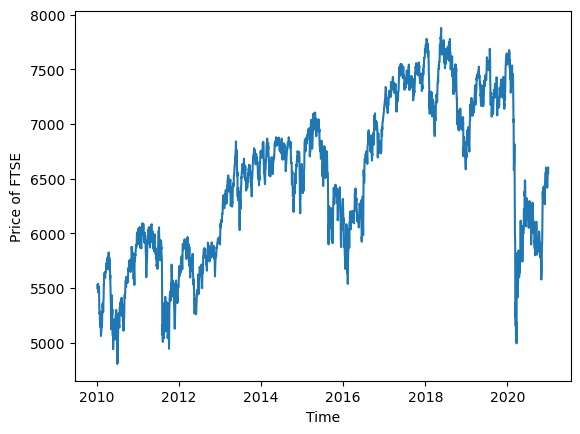

In [70]:
plt.plot(t, y)
plt.xlabel("Time")
plt.ylabel("Price of FTSE")

In [77]:
pc_dif = np.diff(y) / 100

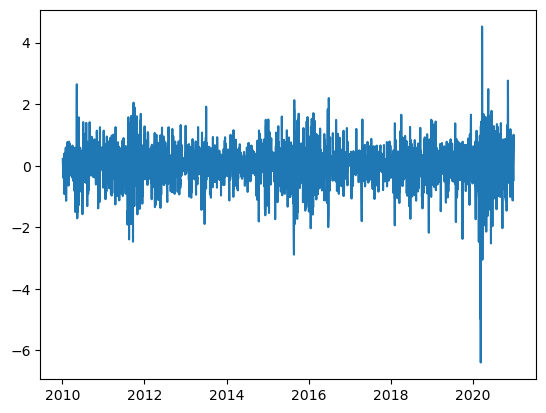

In [78]:
plt.plot(t[1:], pc_dif)

#### ARCH model
* The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms.
* ARCH[1]
$$ r(t) = \mu + a(t) $$
$$ a(t) = \sigma(t) \eta(t) $$
$$ \sigma^2(t) = \alpha_0 + \alpha_1 a(t-1)^2 $$
$$ \eta(t) \sim N(0,1) $$


In [81]:
stan_code = """
data {
    int<lower=0> T; // number of data points
    vector[T] r;
    }

parameters {
    real mu; // average return
    real<lower=0> alpha0; //noise intercept
    real<lower=0, upper=1> alpha1; //noise slope
    }

model {
    // prior
    mu ~ normal(0, 10);
    alpha0 ~ normal(0, 10);
    alpha1 ~ normal(0, 10);

    // likelihood
    for (t in 2:T) {
        r[t] ~ normal(mu, sqrt(alpha0 + alpha1 * (r[t-1]-mu)^2));
    }
}
"""

In [82]:
sm = stan.build(stan_code, data={"T": len(pc_dif), "r": pc_dif})

Building...


Building: 14.5s, done.

In [83]:
posterior = sm.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  59% (4700/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.001106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 11.06 seconds.
  Adjust your expectations accordingly!
  Informat

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'alpha0'}>,
        <Axes: title={'center': 'alpha0'}>],
       [<Axes: title={'center': 'alpha1'}>,
        <Axes: title={'center': 'alpha1'}>]], dtype=object)

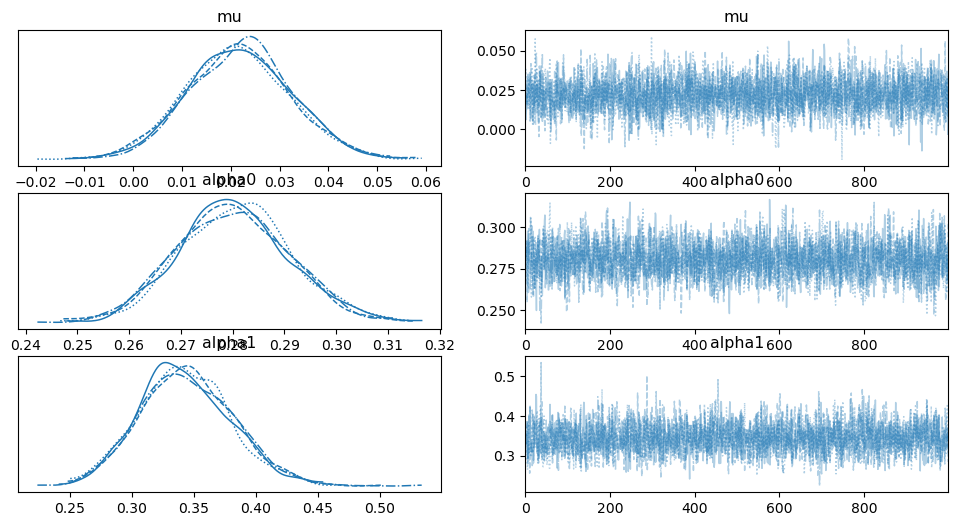

In [84]:
az.plot_trace(posterior)

In [87]:
posterior

<stan.Fit>
Parameters:
    mu: ()
    alpha0: ()
    alpha1: ()
Draws: 4000

In [91]:
mu = posterior["mu"].mean()
alpha0 = posterior["alpha0"].mean()
alpha1 = posterior["alpha1"].mean()

In [92]:
pred = [
    mu + np.sqrt(alpha0 + alpha1 * (pc_dif[t - 1] - mu) ** 2)
    for t in range(1, len(pc_dif))
]

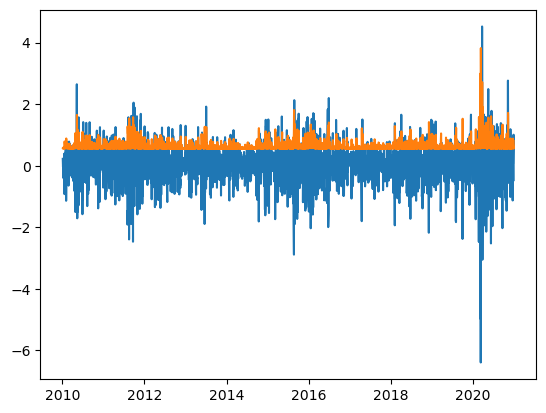

In [97]:
plt.plot(t[1:], pc_dif)
plt.plot(t[2:], pred)

#### GARCH
* The generalized autoregressive conditional heteroscedasticity (GARCH) model is an extension of the ARCH model that incorporates a previous volatility term in the model.
* GARCH[1,1]
$$ \sigma(t)^2 = \alpha_0 + \alpha_1 a(t-1)^2 + \beta_1 \sigma(t-1)^2 $$

In [101]:
stan_code = """
data {
    int<lower=0> T; // number of data points
    vector[T] r;
    real<lower=0> sigma1; // noise at t=1
    }

    parameters {
    real mu; //average return
    real<lower=0> alpha0; // noise intercept
    real<lower=0, upper=1> alpha1; // noise slope
    real<lower=0, upper=(1-alpha1)> beta1; // slope on volatility
    }

transformed parameters {
vector[T] sigma; // volatility
sigma[1] = sigma1;
for (t in 2:T) {
sigma[t] = sqrt(alpha0 + alpha1 * (r[t-1]-mu)^2 + beta1 * sigma[t-1]^2);
}
}

model{
// prior
alpha0 ~ normal(0,10);
alpha1 ~ normal(0,10);
beta1 ~ normal(0,10);

//likelihood
r ~ normal(mu, sigma);
}
"""

In [102]:
sm = stan.build(stan_code, data={"T": len(pc_dif), "r": pc_dif, "sigma1": 0.1})

Building...


Building: 17.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [103]:
posterior = sm.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [126]:
mu_garch = posterior["mu"].mean()
alpha0_garch = posterior["alpha0"].mean()
alpha1_garch = posterior["alpha1"].mean()
beta1_garch = posterior["beta1"].mean()
sigma = posterior["sigma"].mean(axis=1)

In [127]:
posterior["alpha0"].shape

(1, 4000)

In [128]:
posterior["sigma"].shape

(2776, 4000)

In [129]:
alpha0_garch.shape

()

In [130]:
sigma.shape

(2776,)

In [131]:
pred_garch = [
    mu_garch
    + np.sqrt(
        alpha0_garch
        + alpha1_garch * (pc_dif[t - 1] - mu) ** 2
        + beta1_garch * sigma[t - 1] ** 2
    )
    for t in range(1, len(pc_dif))
]

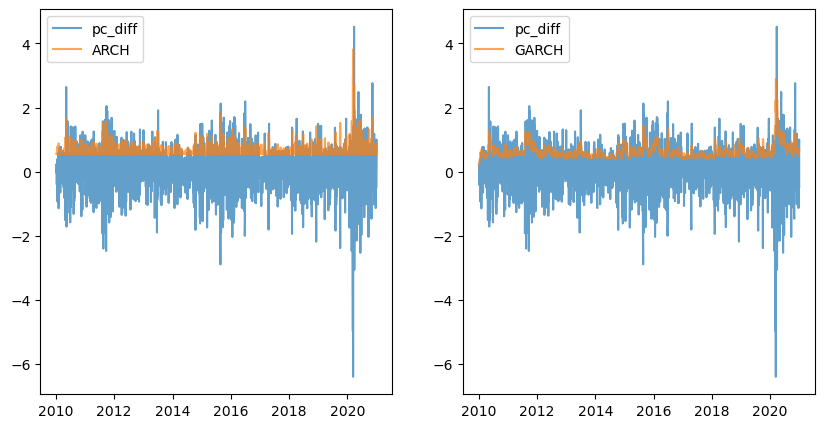

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t[1:], pc_dif, alpha=0.7, label="pc_diff")
ax[0].plot(t[2:], pred, alpha=0.7, label="ARCH")
ax[0].legend()
ax[1].plot(t[1:], pc_dif, alpha=0.7, label="pc_diff")
ax[1].plot(t[2:], pred_garch, alpha=0.7, label="GARCH")
# plt.plot(t[2:], pred, alpha=0.5, label="ARCH")
ax[1].legend()